# Two-particle self consistency (TPSC)

Now, we use the Lindhart function to solve the TPSC approximation explained in the lectures
of André-Marie Tremblay.

@AMT : ADD some text here. 


$$ \chi_{sp}(k, i\omega_n) \equiv \frac{\chi_0(k, i\omega_n)}{1 - \frac{U_{sp}}{2} \chi_0(k, i\omega_n)} $$

$$ \chi_{ch}(k, i\omega_n) \equiv \frac{\chi_0(k, i\omega_n)}{1 + \frac{U_{ch}}{2} \chi_0(k, i\omega_n)} $$

$$ \mathrm{Tr} [ \chi ] \equiv \frac{1}{\beta N_k} \sum_{n, k} \chi(k, i\omega_n) $$



The sum-rule that gives the self-consistency equation is

\begin{equation}
\frac{T}{N}\sum_{\mathbf{q},iq_n} \frac{\chi_0(\mathbf{q},iq_n)}{1-\frac{U_{sp}}{2}\chi_0(\mathbf{q},iq_n)}=n-2\left< n_\uparrow n_\downarrow\right>
\end{equation}

with the ansatz

\begin{equation}
U_{sp}\left<n_\uparrow\right> \left<n_\downarrow\right>=U\left<n_\uparrow n_\downarrow\right>.
\end{equation}

Given the double occupancy, the charge vertex can then be obtained from

\begin{equation}
\frac{T}{N}\sum_{\mathbf{q},iq_n} \frac{\chi_0(\mathbf{q},iq_n)}{1+\frac{U_{cn}}{2}\chi_0(\mathbf{q},iq_n)}=n+2\left< n_\uparrow n_\downarrow\right>-n^2.
\end{equation}



In [7]:
# Imports 
%matplotlib inline
from pytriqs.lattice import BravaisLattice, BrillouinZone
from pytriqs.gf import MeshBrillouinZone, MeshImFreq, Gf, MeshProduct, inverse
from pytriqs.archive import HDFArchive
from pytriqs.plot.mpl_interface import oplot
import numpy as np
from math import cos, pi

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,9) # set default size for all figuresfrom pytriqs.archive import HDFArchivefrom pytriqs.gf import Gf, inverse

from scipy.optimize import fsolve

In [2]:
#reload chi0
with HDFArchive("tpsc.h5", 'r') as R:
    chi0_kw = R['chi0_kw']

In [3]:
def chi_rpa(chi0_kw, U):
    """Compute chi_rpa from chi"""
    chi = chi0_kw.copy()
    return chi * inverse(1 - float(U) * chi)

def trace_chi_kw(chi):
    """Given chi_kw, it computes sum_k sum_\nu chi(k,\nu)""" 
    kmesh, wmesh = chi.mesh.components
    trace = chi.data.sum() / len(kmesh) / wmesh.beta
    # v1 : with density, v2 : without, simple sum
    #trace1 = sum(chi (k.value, all).density() for k in kmesh)/len(kmesh) 
    #print "diff trace ", abs(trace + trace1), trace.real, trace1.real, abs(trace + trace1)/abs(trace)
    assert(np.abs(trace.imag) < 1e-10), trace.imag
    return trace.real

def Usp_root_problem(Usp, chi0, n, U):
    tr_chi_sp = trace_chi_kw(chi_rpa(chi0, U=Usp[0]))
    diff = 2*tr_chi_sp + 0.5 * Usp/U * n**2 - n
    return diff

def Uch_root_problem(Uch, chi0, n, U, docc):
    tr_chi_ch = trace_chi_kw(chi_rpa(chi0, U=-Uch[0]))
    diff = 2*tr_chi_ch - 2 * docc - n + n**2
    return diff

def solve_Usp_and_Uch(chi0, U, n, Usp0=0.1, Uch0=0.1):
    Usp = fsolve(Usp_root_problem, Usp0, args=(chi0, n, U), xtol=1e-2)[0]
    docc = 0.25 * Usp / U * n**2
    Uch = fsolve(Uch_root_problem, Uch0, args=(chi0, n, U, docc), xtol=1e-2)[0]
    return Usp, Uch, docc

## Reproduce paper figure

We want to reproduce the following figure from the
__[paper](https://jp1.journaldephysique.org/articles/jp1/abs/1997/11/jp1v7p1309/jp1v7p1309.html)__

<img src="./img/Fig2.png" alt="Drawing" style="width: 250px;"/>

by calling the function tpsc for a grid of values of the bare U.


In [4]:
n = 1.0
Usp, Uch = 0.3, 0.3

U_vec = np.concatenate((np.arange(0.3, 1., 0.2), np.arange(1., 6., 1.)))    
Usp_vec, Uch_vec, docc_vec = [np.zeros_like(U_vec) for x in xrange(3)]

print ''.join('| %-11s' % s for s in ['n', 'U', 'Usp', 'Uch', 'docc']), '|'
print '-'*67

for idx, U in enumerate(U_vec):
    Usp, Uch, docc = solve_Usp_and_Uch(chi0_kw, U, n, Usp0=Usp, Uch0=Uch)
    Usp_vec[idx], Uch_vec[idx], docc_vec[idx] = Usp, Uch, docc
    print ''.join('| %4.4E ' % x for x in [n, U, Usp, Uch, docc]), '|'

| n          | U          | Usp        | Uch        | docc        |
-------------------------------------------------------------------
| 1.0000E+00 | 3.0000E-01 | 2.9150E-01 | 2.0735E-01 | 2.4292E-01  |
| 1.0000E+00 | 5.0000E-01 | 4.7395E-01 | 4.4817E-01 | 2.3698E-01  |
| 1.0000E+00 | 7.0000E-01 | 6.4648E-01 | 7.1712E-01 | 2.3089E-01  |
| 1.0000E+00 | 9.0000E-01 | 8.0884E-01 | 1.0173E+00 | 2.2468E-01  |
| 1.0000E+00 | 1.0000E+00 | 8.8615E-01 | 1.1799E+00 | 2.2154E-01  |
| 1.0000E+00 | 2.0000E+00 | 1.5186E+00 | 3.3665E+00 | 1.8983E-01  |
| 1.0000E+00 | 3.0000E+00 | 1.9252E+00 | 6.8031E+00 | 1.6043E-01  |
| 1.0000E+00 | 4.0000E+00 | 2.1735E+00 | 1.1694E+01 | 1.3585E-01  |
| 1.0000E+00 | 5.0000E+00 | 2.3261E+00 | 1.8100E+01 | 1.1631E-01  |


## Make plot and compare with paper results

(-0.45, 5.35, -3.0, 20.5)

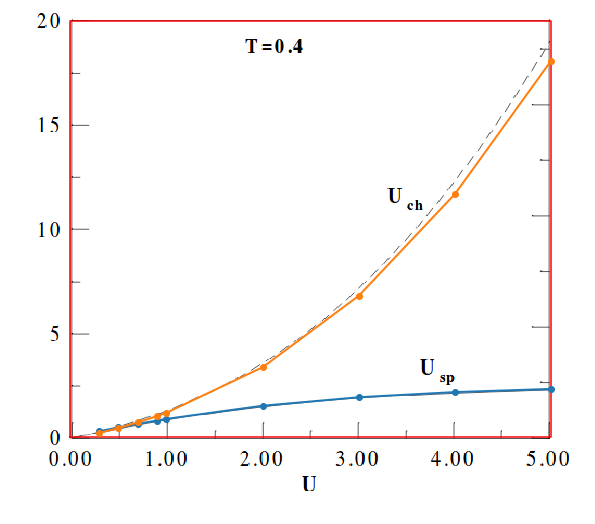

In [8]:
from matplotlib.image import imread

# Some manual adjustements here. May change from one
# machine to another
im = imread("img/Fig2.png")
plt.imshow(im, extent=(-0.45, 5.35, -3, 20.5), aspect='auto')
plt.plot([0,5,5,0,0],[0,0,20,20,0],'-r')

plt.plot(U_vec, Usp_vec, 'o-', label=r'$U_{sp}$', alpha=1, lw=2)
plt.plot(U_vec, Uch_vec, 'o-', label=r'$U_{ch}$', alpha=1, lw=2)

plt.axis('off')

### Note: weakness of RPA

Given the above sum rules, note that in TPSC the following sum-rule, a consequence of the Pauli principle, is satisfied:

\begin{equation}
\frac{T}{N}\sum_{\mathbf{q},iq_n} \left (\frac{\chi_0(\mathbf{q},iq_n)}{1-\frac{U_{sp}}{2}\chi_0(\mathbf{q},iq_n)}+\frac{\chi_0(\mathbf{q},iq_n)}{1+\frac{U_{ch}}{2}\chi_0(\mathbf{q},iq_n)}\right)=2n-n^2.
\end{equation}

Note that the right-hand side is independent of interactions.

    Compute the same quantity, but in the RPA approximation, 
    and make a plot of how much RPA violates the Pauli principle.

In [6]:
## TODO !!
# Maybe we can use this in the exam?